## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [32]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [33]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Set themes, styles and color palette for seaborn charts
sns.set_theme(style='darkgrid', context='poster')
sns.set_palette(palette='pastel', n_colors=10)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.titlesize"] = 14 
plt.rcParams["axes.labelsize"] = 12 
plt.rcParams["xtick.labelsize"] = 10 
plt.rcParams["ytick.labelsize"] = 10 

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [34]:
# Opening JSON file
with open('complaints-2021-05-14_08_16.json', 'r') as f: # Write the path to your data file and load it
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    df=pd.json_normalize(data)

## Data preparation

In [35]:
# Inspect the dataframe to understand the given data.
print(df.shape)

(25, 22)


In [36]:
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             25 non-null     object 
 1   _type                              25 non-null     object 
 2   _id                                25 non-null     object 
 3   _score                             25 non-null     float64
 4   _source.tags                       3 non-null      object 
 5   _source.zip_code                   24 non-null     object 
 6   _source.complaint_id               25 non-null     object 
 7   _source.issue                      25 non-null     object 
 8   _source.date_received              25 non-null     object 
 9   _source.state                      25 non-null     object 
 10  _source.consumer_disputed          25 non-null     object 
 11  _source.product                    25 non-null     object 
 

In [38]:
df.isnull().sum()

_index                                0
_type                                 0
_id                                   0
_score                                0
_source.tags                         22
_source.zip_code                      1
_source.complaint_id                  0
_source.issue                         0
_source.date_received                 0
_source.state                         0
_source.consumer_disputed             0
_source.product                       0
_source.company_response              0
_source.company                       0
_source.submitted_via                 0
_source.date_sent_to_company          0
_source.company_public_response      25
_source.sub_product                   0
_source.timely                        0
_source.complaint_what_happened       0
_source.sub_issue                     4
_source.consumer_consent_provided     0
dtype: int64

In [39]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [40]:
#Assign new column names
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code', 
    'complaint_id', 'issue', 'date_received', 
    'state', 'consumer_disputed', 'product', 
    'company_response', 'company', 'submitted_via', 
    'date_sent_to_company', 'company_public_response',
    'sub_product', 'timely', 
    'complaint', 'sub_issue', 
    'consumer_consent_provided'
]

In [41]:
#Assign nan in place of blanks in the complaints column
df.replace({'complaint': {'': np.nan}}, inplace=True)

In [42]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint'], inplace=True)

In [43]:
df.shape

(11, 22)

In [44]:
df['complaint'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [45]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation marks
    text = re.sub(r'\w*\d\w*', '', text) # Remove words with numbers

    return text

In [46]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

import nltk
# Downloading the following based on trial and error method
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [47]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint']].copy()

df_clean['cleaned_complaint'] = df_clean['complaint'].apply(clean_text)
df_clean['lemmatized_complaint'] = df_clean['cleaned_complaint'].apply(lemmatize_text)

In [48]:
df_clean.head(1)

,complaint,cleaned_complaint,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]"


In [49]:
#Write your function to extract the POS tags
def keep_nouns(text): # Changed the function name as it's the same as pos_tag from nltk library
  tagged = pos_tag(text)
  nouns = [word for word, tag in tagged if tag == 'NN'] # Filtering nouns
  return ' '.join(nouns)

df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].apply(keep_nouns) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [50]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"[chase, card, wa, reported, on, however, fraudulent, application, have, been, submitted, my, identity, without, my, consent, to, fraudulently, obtain, service, do, not, extend, credit, without, verifying, the, identity, of, the, applicant]",card wa application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I i

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




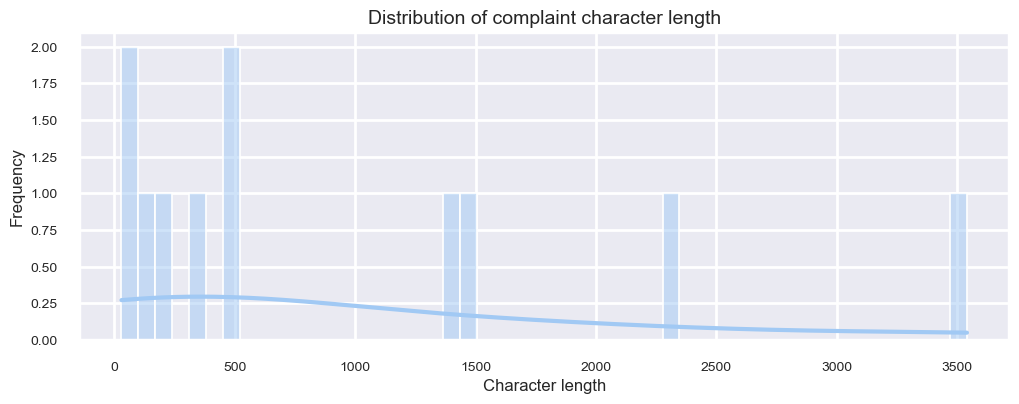

In [51]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint'].str.len()

sns.histplot(df_clean['complaint_length'], bins=50, kde=True)
plt.title('Distribution of complaint character length')
plt.xlabel('Character length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

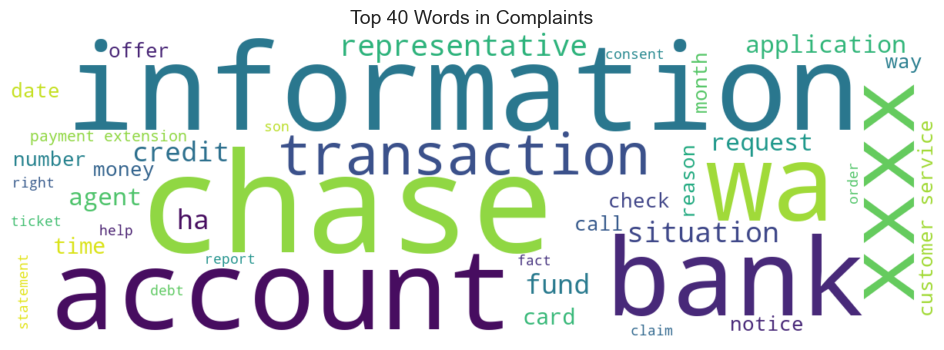

In [52]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

all_text = ' '.join(df_clean['complaint_POS_removed'].dropna())

wordcloud = WordCloud(width=1200, height=400, max_words=40, background_color='white').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Words in Complaints")
plt.show()

In [53]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [54]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_uni = CountVectorizer(ngram_range=(1,1), stop_words='english')
X_uni = vectorizer_uni.fit_transform(df_clean['complaint_clean'].dropna())

unigram_freq = pd.DataFrame(X_uni.toarray(), columns=vectorizer_uni.get_feature_names_out()).sum()

In [55]:
#Print the top 10 words in the unigram frequency
unigram_freq.head(10)

account        16
address         1
advance         1
advertising     1
agent           6
app             2
applicant       1
application     6
associate       1
auto            3
dtype: int64

In [56]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_bi = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_bi = vectorizer_bi.fit_transform(df_clean['complaint_clean'].dropna())

bigram_freq = pd.DataFrame(X_bi.toarray(), columns=vectorizer_bi.get_feature_names_out()).sum()

In [57]:
#Print the top 10 words in the bigram frequency
bigram_freq.head(10)

account advance        1
account application    1
account auto           1
account branch         1
account credit         1
account date           1
account debit          1
account fund           2
account ha             1
account look           2
dtype: int64

In [58]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_tri = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_tri = vectorizer_tri.fit_transform(df_clean['complaint_clean'].dropna())

trigram_freq = pd.DataFrame(X_tri.toarray(), columns=vectorizer_tri.get_feature_names_out()).sum()

In [59]:
#Print the top 10 words in the trigram frequency
trigram_freq.head(10)

account advance help                  1
account application representative    1
account auto xxxx                     1
account branch fund                   1
account credit report                 1
account date xxxxxxxx                 1
account debit card                    1
account fund chase                    1
account fund statement                1
account ha bind                       1
dtype: int64

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [60]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [61]:
#All masked texts has been removed
df_clean.head(2)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent,355,i card agent upgrade date agent wa information order account date consent recording agent


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



